In [1]:
"""This benchmark presents a perfomanse deeplabv3 architecture applied to rupture detection problem.
   Here is used the pretrained model Mobilenet_v2.
   Epoch number - 1(computational expensive on laptop)

"""

'This benchmark presents a perfomanse deeplabv3 architecture applied to rupture detection problem.\n   Here is used the pretrained model Mobilenet_v2.\n   Epoch number - 1(computational expensive on laptop)\n\n'

In [0]:
#@title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [0]:
#@title Helper methods


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_rupture_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_rupture_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')
  
  '''
  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()
  


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
'''    

In [10]:
#@title Select and download models {display-mode: "form"}

MODEL_NAME = 'wzl_segment_model'


_DOWNLOAD_URL_PREFIX = 'https://drive.google.com/uc?export=download&'
_MODEL_URLS = {
    'wzl_segment_model':
         'id=1LswHlJJKhpMczT6K6-qSClPjvTMi48vi'
}

_TARBALL_NAME = 'rupture_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading Deeplab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully')

downloading model, this might take a while...
download completed! loading Deeplab model...
model loaded successfully


## Run on sample images

running deeplab on image https://drive.google.com/uc?export=download&id=1Vw0BSJQ28qVf3PGh24ufdDAwUKMeGvRC...
running deeplab on image https://drive.google.com/uc?export=download&id=1AUVe2F18TdRhTsWTmtaJbe7BgbuxMNMc...
running deeplab on image https://drive.google.com/uc?export=download&id=1kdPNhRbIPLF5uFjd5C0J7wH5XDtWACq6...
running deeplab on image https://drive.google.com/uc?export=download&id=12CJLEltu-D7ZDhU78sObQ6GjvyKdQNrJ...
running deeplab on image https://drive.google.com/uc?export=download&id=1nx1F7HdjNXOz4Yu3o5PW5Cpy6lvqDBSL...


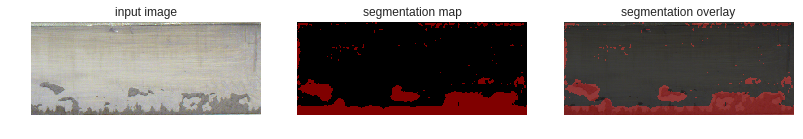

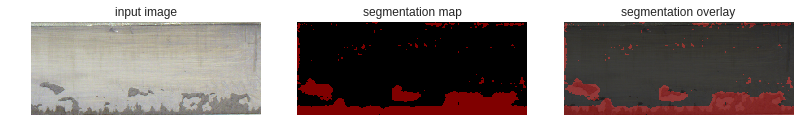

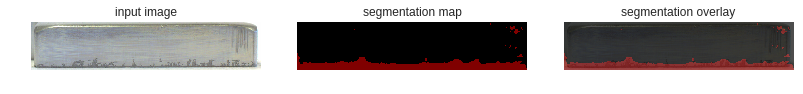

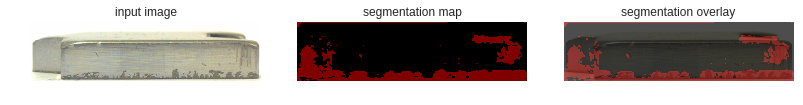

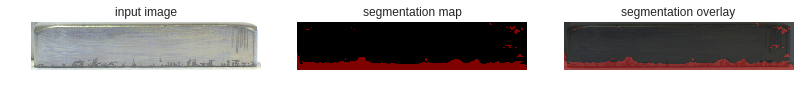

In [11]:
 #IMAGES = '1Vw0BSJQ28qVf3PGh24ufdDAwUKMeGvRC' # @param ['1Vw0BSJQ28qVf3PGh24ufdDAwUKMeGvRC', '1AUVe2F18TdRhTsWTmtaJbe7BgbuxMNMc',   '1kdPNhRbIPLF5uFjd5C0J7wH5XDtWACq6','12CJLEltu-D7ZDhU78sObQ6GjvyKdQNrJ','1nx1F7HdjNXOz4Yu3o5PW5Cpy6lvqDBSL']
 IMAGES_LIST = ['1Vw0BSJQ28qVf3PGh24ufdDAwUKMeGvRC', '1AUVe2F18TdRhTsWTmtaJbe7BgbuxMNMc',   '1kdPNhRbIPLF5uFjd5C0J7wH5XDtWACq6','12CJLEltu-D7ZDhU78sObQ6GjvyKdQNrJ','1nx1F7HdjNXOz4Yu3o5PW5Cpy6lvqDBSL']
 IMAGE_URL = ''  #@param {type: "string"}

_SAMPLE_URL = ('https://drive.google.com/uc?export=download&id=%s')




def run_visualization(url):
  """Inferences DeepLab model and visulizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return
  
  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)
  
image_list_url =[_SAMPLE_URL % i  for i in IMAGES_LIST]

for item in image_list_url:
  run_visualization(item)
